In [1]:
!git clone https://github.com/maria-natale/ProgettoFVAB

Cloning into 'ProgettoFVAB'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 152 (delta 48), reused 85 (delta 21), pack-reused 0
Receiving objects: 100% (152/152), 163.85 KiB | 4.10 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
!python "/content/ProgettoFVAB/Code/create_datasetcsv_66.py"

Traceback (most recent call last):
  File "/content/ProgettoFVAB/Code/create_datasetcsv_66.py", line 113, in <module>
    create_folders()
  File "/content/ProgettoFVAB/Code/create_datasetcsv_66.py", line 24, in create_folders
    os.chdir(os.path.join(path_drive, dataset_dir))
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Casillo&Natale/dataset_4_7/datasetCSV'


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
import os
import pandas as pd
import numpy as np

path_git = '/content/ProgettoFVAB'
filename = '1_4_7'
path_drive = '/content/drive/MyDrive/Casillo&Natale'
dataset_dir = 'dataset_1_4_7/datasetCSV'
LANGUAGES = {1: 'Italiano',
    4:'Spagnolo',
  7: 'Giapponese'}

MAX_LINES = 360

**Eseguire da qua**

In [53]:
from sklearn.preprocessing import label_binarize
os.chdir(os.path.join(path_drive, dataset_dir, 'csv'))
x_train = pd.read_csv(filename+"_all_train.csv")
x_test = pd.read_csv(filename+"_all_test.csv")
y_train = pd.read_csv(filename+"targets_all_train.csv")
y_test = pd.read_csv(filename+"targets_all_test.csv")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


number_train = 40/100 * x_train.shape[0]
number_test = 40/100 * x_test.shape[0]

(95900, 66)
(95900, 1)
(24150, 66)
(24150, 1)


**NO**

In [ ]:
print(x_train.shape)
print(x_test.shape)
x_train = x_train.loc[:number_train][:]
y_train = y_train.loc[:number_train][:]
x_test = x_test.loc[:number_test][:]
y_test = y_test.loc[:number_test][:]



(68250, 66)
(19250, 66)


In [54]:
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


#Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into 3-D array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Initialising the RNN
model = Sequential()
model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[0], 1))))
model.add(Dropout(0.2))

# Adding a second LSTM layer and Dropout layer
model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
model.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout layer
model.add(Bidirectional(LSTM(units = 50)))
model.add(Dropout(0.2))



# Adding the output layer
# For Full connection layer we use dense
model.add(Dense(8, activation='softmax'))


In [55]:
import tensorflow as tf
#compile and fit the model on 30 epochs
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)



In [56]:
model.fit(x_train, y_train, epochs = 1, batch_size = 50)
model.summary()

1918/1918 [==============================] - 310s 157ms/step - loss: 1.0207 - accuracy: 0.4881
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (50, 66, 100)             20800     
_________________________________________________________________
dropout_15 (Dropout)         (50, 66, 100)             0         
_________________________________________________________________
bidirectional_16 (Bidirectio (50, 66, 100)             60400     
_________________________________________________________________
dropout_16 (Dropout)         (50, 66, 100)             0         
_________________________________________________________________
bidirectional_17 (Bidirectio (50, 100)                 60400     
_________________________________________________________________
dropout_17 (Dropout)         (50, 100)                 0         
_________________________

# Nuova sezione

In [57]:

#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into 3-D array
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [58]:
model.evaluate(x_test, y_test)

755/755 [==============================] - 30s 35ms/step - loss: 1.1755 - accuracy: 0.3753


[1.1755318641662598, 0.3753209114074707]

In [59]:


#check predicted values

predictions = model.predict_classes(x_test) 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predictions

array([4, 4, 4, ..., 4, 4, 4])

In [71]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

print(multilabel_confusion_matrix(y_test, predictions, labels = list(LANGUAGES.keys())))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in list(LANGUAGES.keys()):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])


[[[ 8381  9469]
  [ 1877  4423]]

 [[ 9536  4114]
  [ 7323  3177]]

 [[15297  1503]
  [ 5886  1464]]]


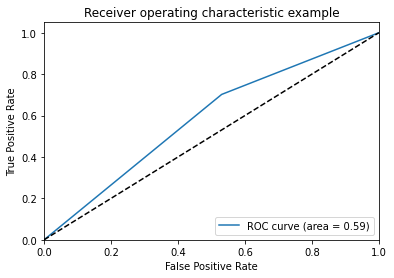

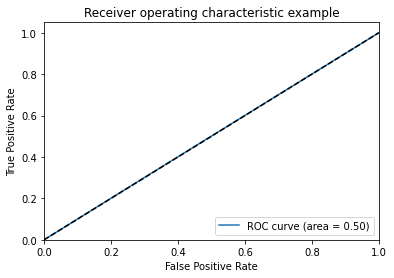

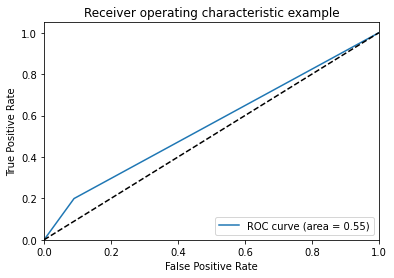

In [62]:
import matplotlib.pyplot as plt
# Plot of a ROC curve for a specific class
for i in list(LANGUAGES.keys()):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()